##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Quantum Convolutional Neural Network

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/quantum/tutorials/qcnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/quantum/blob/master/docs/tutorials/qcnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/quantum/blob/master/docs/tutorials/qcnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/quantum/docs/tutorials/qcnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial implements a simplified <a href="https://www.nature.com/articles/s41567-019-0648-8" class="external">Quantum Convolutional Neural Network</a> (QCNN), a proposed quantum analogue to a classical convolutional neural network that is also *translationally invariant*.

This example demonstrates how to detect certain properties of a quantum data source, such as a quantum sensor or a complex simulation from a device. The quantum data source being a <a href="https://arxiv.org/pdf/quant-ph/0504097.pdf" class="external">cluster state</a> that may or may not have an excitation—what the QCNN will learn to detect (The dataset used in the paper was SPT phase classification).

## Setup

In [2]:
!pip install -q tensorflow==2.1.0

Install TensorFlow Quantum:

In [3]:
!pip install -q tensorflow-quantum

Now import TensorFlow and the module dependencies:

In [4]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

## 1. Build a QCNN

### 1.1 Assemble circuits in a TensorFlow graph

TensorFlow Quantum (TFQ) provides layer classes designed for in-graph circuit construction. One example is the `tfq.layers.AddCircuit` layer that inherits from `tf.keras.Layer`. This layer can either prepend or append to the input batch of circuits, as shown in the following figure.

<img src="./images/qcnn_1.png" width="700">

The following snippet uses this layer:

In [5]:
qubit = cirq.GridQubit(0, 0)

# Define some circuits.
circuit1 = cirq.Circuit(cirq.X(qubit))
circuit2 = cirq.Circuit(cirq.H(qubit))

# Convert to a tensor.
input_circuit_tensor = tfq.convert_to_tensor([circuit1, circuit2])

# Define a circuit that we want to append
y_circuit = cirq.Circuit(cirq.Y(qubit))

# Instantiate our layer
y_appender = tfq.layers.AddCircuit()

# Run our circuit tensor through the layer and save the output.
output_circuit_tensor = y_appender(input_circuit_tensor, append=y_circuit)

Examine the input tensor:

In [6]:
print(tfq.from_tensor(input_circuit_tensor))

[cirq.Circuit([
    cirq.Moment(
        cirq.X(cirq.GridQubit(0, 0)),
    ),
])
 cirq.Circuit([
    cirq.Moment(
        cirq.H(cirq.GridQubit(0, 0)),
    ),
])]


And examine the output tensor:

In [7]:
print(tfq.from_tensor(output_circuit_tensor))

[cirq.Circuit([
    cirq.Moment(
        cirq.X(cirq.GridQubit(0, 0)),
    ),
    cirq.Moment(
        cirq.Y(cirq.GridQubit(0, 0)),
    ),
])
 cirq.Circuit([
    cirq.Moment(
        cirq.H(cirq.GridQubit(0, 0)),
    ),
    cirq.Moment(
        cirq.Y(cirq.GridQubit(0, 0)),
    ),
])]


While it is possible to run the examples below without using `tfq.layers.AddCircuit`, it's a good opportunity to understand how complex functionality can be embedded into TensorFlow compute graphs.

### 1.2 Problem overview

You will prepare a *cluster state* and train a quantum classifier to detect if it is "excited" or not. The cluster state is highly entangled but not necessarily difficult for a classical computer. For clarity, this is a simpler dataset than the one used in the paper.

For this classification task you will implement a deep <a href="https://arxiv.org/pdf/quant-ph/0610099.pdf" class="external">MERA</a>-like QCNN architecture since:

1.   Like the QCNN, the cluster state on a ring is translationally invariant.
2.   The cluster state is highly entangled.

This architecture should be effective at reducing entanglement, obtaining the classification by reading out a single qubit.

<img src="./images/qcnn_2.png" width="1000">

An "excited" cluster state is defined as a cluster state that had a `cirq.rx` gate applied to any of its qubits. Qconv and QPool are discussed later in this tutorial.

### 1.3 Building blocks for TensorFlow

<img src="./images/qcnn_3.png" width="1000">

One way to solve this problem with TensorFlow Quantum is to implement the following:

1. The input to the model is a circuit tensor—either an empty circuit or an X gate on a particular qubit indicating an excitation.
2. The rest of the model's quantum components are constructed with `tfq.layers.AddCircuit` layers.
3. For inference a `tfq.layers.PQC` layer is used. This reads $\langle \hat{Z} \rangle$ and compares it to a label of 1 for an excited state, or -1 for a non-excited state.

### 1.4 Data
Before building your model, you can generate your data. In this case it's going to be excitations to the cluster state (The original paper uses a more complicated dataset). Excitations are represented with `cirq.rx` gates. A large enough rotation is deemed an excitation and is labeled `1` and a rotation that isn't large enough is labeled `-1` and deemed not an excitation.

In [8]:
def generate_data(qubits):
    """Generate training and testing data."""
    n_rounds = 20  # Produces n_rounds * n_qubits datapoints.
    excitations = []
    labels = []
    for n in range(n_rounds):
        for bit in qubits:
            rng = np.random.uniform(-np.pi, np.pi)
            excitations.append(cirq.Circuit(cirq.rx(rng)(bit)))
            labels.append(1 if (-np.pi / 2) <= rng <= (np.pi / 2) else -1)

    split_ind = int(len(excitations) * 0.7)
    train_excitations = excitations[:split_ind]
    test_excitations = excitations[split_ind:]

    train_labels = labels[:split_ind]
    test_labels = labels[split_ind:]

    return tfq.convert_to_tensor(train_excitations), np.array(train_labels), \
        tfq.convert_to_tensor(test_excitations), np.array(test_labels)

You can see that just like with regular machine learning you create a training and testing set to use to benchmark the model. You can quickly look at some datapoints with:

In [9]:
sample_points, sample_labels, _, __ = generate_data(cirq.GridQubit.rect(1, 4))
print('Input:', tfq.from_tensor(sample_points)[0], 'Output:', sample_labels[0])
print('Input:', tfq.from_tensor(sample_points)[1], 'Output:', sample_labels[1])

Input: (0, 0): ───Rx(0.03π)─── Output: 1
Input: (0, 1): ───Rx(-0.12π)─── Output: 1


### 1.5 Define layers

Now define the layers shown in the figure above in TensorFlow.

#### 1.5.1 Cluster state

The first step is to define the <a href="https://arxiv.org/pdf/quant-ph/0504097.pdf" class="external">cluster state</a> using <a href="https://github.com/quantumlib/Cirq" class="external">Cirq</a>, a Google-provided framework for programming quantum circuits. Since this is a static part of the model, embed it using the `tfq.layers.AddCircuit` functionality.

In [10]:
def cluster_state_circuit(bits):
    """Return a cluster state on the qubits in `bits`."""
    circuit = cirq.Circuit()
    circuit.append(cirq.H.on_each(bits))
    for this_bit, next_bit in zip(bits, bits[1:] + [bits[0]]):
        circuit.append(cirq.CZ(this_bit, next_bit))
    return circuit

Display a cluster state circuit for a rectangle of <a href="https://cirq.readthedocs.io/en/stable/generated/cirq.GridQubit.html" class="external"><code>cirq.GridQubit</code></a>s:

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


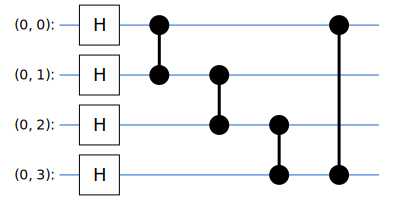

In [11]:
SVGCircuit(cluster_state_circuit(cirq.GridQubit.rect(1, 4)))

#### 1.5.2 QCNN layers

Define the layers that make up the model using the <a href="https://arxiv.org/abs/1810.03787" class="external">Cong and Lukin QCNN paper</a>. There are a few prerequisites:

* The one- and two-qubit parameterized unitary matrices from the <a href="https://arxiv.org/abs/quant-ph/0507171" class="external">Tucci paper</a>.
* A general parameterized two-qubit pooling operation.

In [12]:
def one_qubit_unitary(bit, symbols):
    """Make a Cirq circuit enacting a rotation of the bloch sphere about the X,
    Y and Z axis, that depends on the values in `symbols`.
    """
    return cirq.Circuit(
        cirq.X(bit)**symbols[0],
        cirq.Y(bit)**symbols[1],
        cirq.Z(bit)**symbols[2])


def two_qubit_unitary(bits, symbols):
    """Make a Cirq circuit that creates an arbitrary two qubit unitary."""
    circuit = cirq.Circuit()
    circuit += one_qubit_unitary(bits[0], symbols[0:3])
    circuit += one_qubit_unitary(bits[1], symbols[3:6])
    circuit += [cirq.ZZ(*bits)**symbols[6]]
    circuit += [cirq.YY(*bits)**symbols[7]]
    circuit += [cirq.XX(*bits)**symbols[8]]
    circuit += one_qubit_unitary(bits[0], symbols[9:12])
    circuit += one_qubit_unitary(bits[1], symbols[12:])
    return circuit


def two_qubit_pool(source_qubit, sink_qubit, symbols):
    """Make a Cirq circuit to do a parameterized 'pooling' operation, which
    attempts to reduce entanglement down from two qubits to just one."""
    pool_circuit = cirq.Circuit()
    sink_basis_selector = one_qubit_unitary(sink_qubit, symbols[0:3])
    source_basis_selector = one_qubit_unitary(source_qubit, symbols[3:6])
    pool_circuit.append(sink_basis_selector)
    pool_circuit.append(source_basis_selector)
    pool_circuit.append(cirq.CNOT(control=source_qubit, target=sink_qubit))
    pool_circuit.append(sink_basis_selector**-1)
    return pool_circuit

To see what you created, print out the one-qubit unitary circuit:

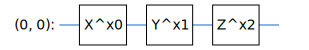

In [13]:
SVGCircuit(one_qubit_unitary(cirq.GridQubit(0, 0), sympy.symbols('x0:3')))

And the two-qubit unitary circuit:

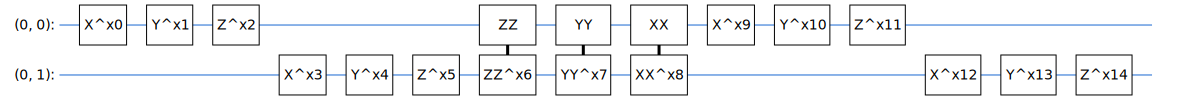

In [14]:
SVGCircuit(two_qubit_unitary(cirq.GridQubit.rect(1, 2), sympy.symbols('x0:15')))

And the two-qubit pooling circuit:

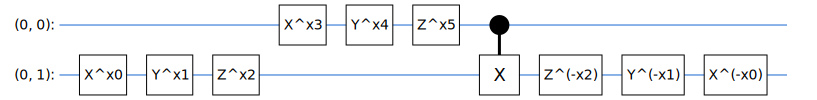

In [15]:
SVGCircuit(two_qubit_pool(*cirq.GridQubit.rect(1, 2), sympy.symbols('x0:6')))

##### 1.5.2.1 Quantum convolution

As in the <a href="https://arxiv.org/abs/1810.03787" class="external">Cong and Lukin</a> paper, define the 1D quantum convolution as the application of a two-qubit parameterized unitary to every pair of adjacent qubits with a stride of one.

In [16]:
def quantum_conv_circuit(bits, symbols):
    """Quantum Convolution Layer following the above diagram.
    Return a Cirq circuit with the cascade of `two_qubit_unitary` applied
    to all pairs of qubits in `bits` as in the diagram above.
    """
    circuit = cirq.Circuit()
    for first, second in zip(bits[0::2], bits[1::2]):
        circuit += two_qubit_unitary([first, second], symbols)
    for first, second in zip(bits[1::2], bits[2::2] + [bits[0]]):
        circuit += two_qubit_unitary([first, second], symbols)
    return circuit

Display the (very horizontal) circuit:

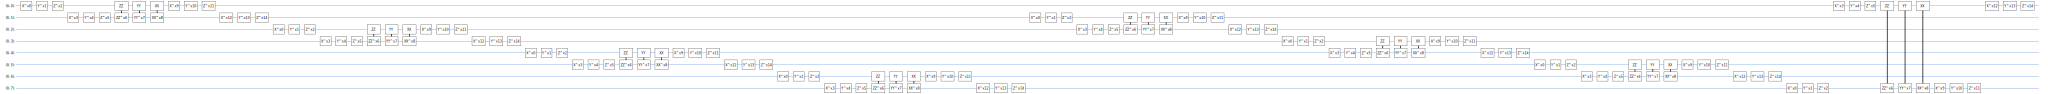

In [17]:
SVGCircuit(
    quantum_conv_circuit(cirq.GridQubit.rect(1, 8), sympy.symbols('x0:15')))

##### 1.5.2.2 Quantum pooling

A quantum pooling layer pools from $N$ qubits to $\frac{N}{2}$ qubits using the two-qubit pool defined above.

In [18]:
def quantum_pool_circuit(source_bits, sink_bits, symbols):
    """A layer that specifies a quantum pooling operation.
    A Quantum pool tries to learn to pool the relevant information from two
    qubits onto 1.
    """
    circuit = cirq.Circuit()
    for source, sink in zip(source_bits, sink_bits):
        circuit += two_qubit_pool(source, sink, symbols)
    return circuit

Examine a pooling component circuit:

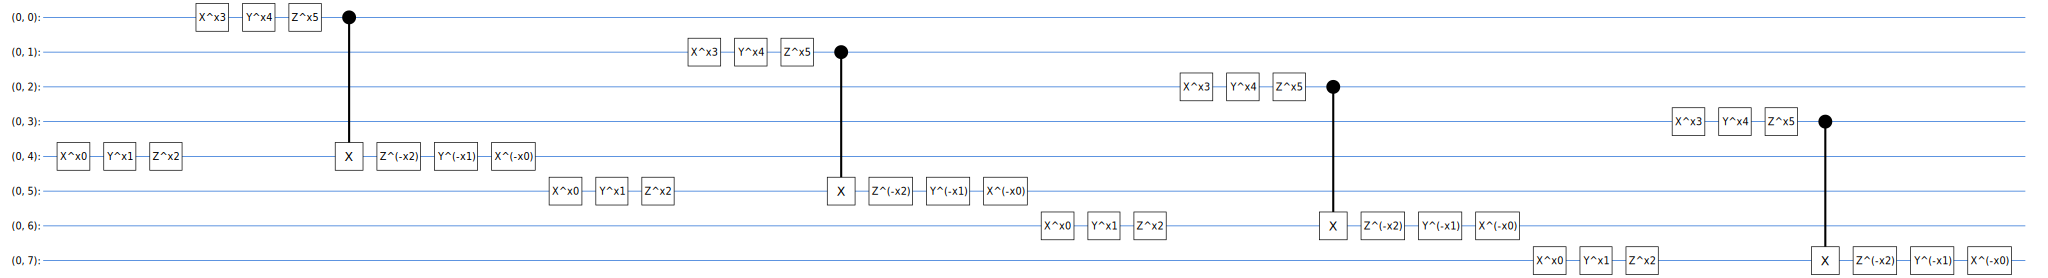

In [19]:
test_bits = cirq.GridQubit.rect(1, 8)

SVGCircuit(
    quantum_pool_circuit(test_bits[:4], test_bits[4:], sympy.symbols('x0:6')))

### 1.6 Model definition

Now use the defined layers to construct a purely quantum CNN. Start with eight qubits, pool down to one, then measure $\langle \hat{Z} \rangle$.

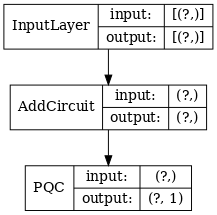

In [20]:
def create_model_circuit(qubits):
    """Create sequence of alternating convolution and pooling operators 
    which gradually shrink over time."""
    model_circuit = cirq.Circuit()
    symbols = sympy.symbols('qconv0:63')
    # Cirq uses sympy.Symbols to map learnable variables. TensorFlow Quantum
    # scans incoming circuits and replaces these with TensorFlow variables.
    model_circuit += quantum_conv_circuit(qubits, symbols[0:15])
    model_circuit += quantum_pool_circuit(qubits[:4], qubits[4:],
                                          symbols[15:21])
    model_circuit += quantum_conv_circuit(qubits[4:], symbols[21:36])
    model_circuit += quantum_pool_circuit(qubits[4:6], qubits[6:],
                                          symbols[36:42])
    model_circuit += quantum_conv_circuit(qubits[6:], symbols[42:57])
    model_circuit += quantum_pool_circuit([qubits[6]], [qubits[7]],
                                          symbols[57:63])
    return model_circuit


# Create our qubits and readout operators in Cirq.
cluster_state_bits = cirq.GridQubit.rect(1, 8)
readout_operators = cirq.Z(cluster_state_bits[-1])

# Build a sequential model enacting the logic in 1.3 of this notebook.
# Here you are making the static cluster state prep as a part of the AddCircuit and the
# "quantum datapoints" are coming in the form of excitation
excitation_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
cluster_state = tfq.layers.AddCircuit()(
    excitation_input, prepend=cluster_state_circuit(cluster_state_bits))

quantum_model = tfq.layers.PQC(create_model_circuit(cluster_state_bits),
                               readout_operators)(cluster_state)

qcnn_model = tf.keras.Model(inputs=[excitation_input], outputs=[quantum_model])

# Show the keras plot of the model
tf.keras.utils.plot_model(qcnn_model,
                          show_shapes=True,
                          show_layer_names=False,
                          dpi=70)

### 1.7 Train the model

Train the model over the full batch to simplify this example.

In [21]:
# Generate some training data.
train_excitations, train_labels, test_excitations, test_labels = generate_data(
    cluster_state_bits)


# Custom accuracy metric.
@tf.function
def custom_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true)
    y_pred = tf.map_fn(lambda x: 1.0 if x >= 0 else -1.0, y_pred)
    return tf.keras.backend.mean(tf.keras.backend.equal(y_true, y_pred))


qcnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
                   loss=tf.losses.mse,
                   metrics=[custom_accuracy])

history = qcnn_model.fit(x=train_excitations,
                         y=train_labels,
                         batch_size=16,
                         epochs=25,
                         verbose=1,
                         validation_data=(test_excitations, test_labels))

Train on 112 samples, validate on 48 samples
Epoch 1/25


 16/112 [===>..........................] - ETA: 28s - loss: 1.0354 - custom_accuracy: 0.1875

 32/112 [=======>......................] - ETA: 13s - loss: 0.9925 - custom_accuracy: 0.4062

 48/112 [===========>..................] - ETA: 8s - loss: 0.9449 - custom_accuracy: 0.5000 

 64/112 [================>.............] - ETA: 5s - loss: 0.9274 - custom_accuracy: 0.5469

 80/112 [====================>.........] - ETA: 3s - loss: 0.9194 - custom_accuracy: 0.5625

 96/112 [========================>.....] - ETA: 1s - loss: 0.9002 - custom_accuracy: 0.6250

112/112 [==============================] - 9s 81ms/sample - loss: 0.8930 - custom_accuracy: 0.6518 - val_loss: 0.8080 - val_custom_accuracy: 0.8750


Epoch 2/25


 16/112 [===>..........................] - ETA: 3s - loss: 0.7887 - custom_accuracy: 1.0000

 32/112 [=======>......................] - ETA: 3s - loss: 0.8302 - custom_accuracy: 0.8750

 48/112 [===========>..................] - ETA: 2s - loss: 0.8554 - custom_accuracy: 0.8125

 64/112 [================>.............] - ETA: 1s - loss: 0.8399 - custom_accuracy: 0.7969

 80/112 [====================>.........] - ETA: 1s - loss: 0.8329 - custom_accuracy: 0.8000

 96/112 [========================>.....] - ETA: 0s - loss: 0.8244 - custom_accuracy: 0.8125

112/112 [==============================] - 5s 42ms/sample - loss: 0.8031 - custom_accuracy: 0.8214 - val_loss: 0.7442 - val_custom_accuracy: 0.8750


Epoch 3/25


 16/112 [===>..........................] - ETA: 3s - loss: 0.7189 - custom_accuracy: 0.8125

 32/112 [=======>......................] - ETA: 3s - loss: 0.7330 - custom_accuracy: 0.8438

 48/112 [===========>..................] - ETA: 2s - loss: 0.7574 - custom_accuracy: 0.8333

 64/112 [================>.............] - ETA: 1s - loss: 0.7616 - custom_accuracy: 0.8281

 80/112 [====================>.........] - ETA: 1s - loss: 0.7763 - custom_accuracy: 0.8250

 96/112 [========================>.....] - ETA: 0s - loss: 0.7660 - custom_accuracy: 0.8438

112/112 [==============================] - 5s 41ms/sample - loss: 0.7519 - custom_accuracy: 0.8571 - val_loss: 0.7156 - val_custom_accuracy: 0.8750


Epoch 4/25


 16/112 [===>..........................] - ETA: 3s - loss: 0.7549 - custom_accuracy: 1.0000

 32/112 [=======>......................] - ETA: 3s - loss: 0.7269 - custom_accuracy: 0.9375

 48/112 [===========>..................] - ETA: 2s - loss: 0.6803 - custom_accuracy: 0.9375

 64/112 [================>.............] - ETA: 1s - loss: 0.7083 - custom_accuracy: 0.9062

 80/112 [====================>.........] - ETA: 1s - loss: 0.6850 - custom_accuracy: 0.9250

 96/112 [========================>.....] - ETA: 0s - loss: 0.6768 - custom_accuracy: 0.9271

112/112 [==============================] - 5s 42ms/sample - loss: 0.6634 - custom_accuracy: 0.9196 - val_loss: 0.5396 - val_custom_accuracy: 0.9792


Epoch 5/25


 16/112 [===>..........................] - ETA: 3s - loss: 0.5957 - custom_accuracy: 0.9375

 32/112 [=======>......................] - ETA: 3s - loss: 0.5470 - custom_accuracy: 0.9688

 48/112 [===========>..................] - ETA: 2s - loss: 0.5172 - custom_accuracy: 0.9583

 64/112 [================>.............] - ETA: 1s - loss: 0.5488 - custom_accuracy: 0.9375

 80/112 [====================>.........] - ETA: 1s - loss: 0.5419 - custom_accuracy: 0.9500

 96/112 [========================>.....] - ETA: 0s - loss: 0.5225 - custom_accuracy: 0.9479

112/112 [==============================] - 5s 42ms/sample - loss: 0.5197 - custom_accuracy: 0.9554 - val_loss: 0.4595 - val_custom_accuracy: 0.9375


Epoch 6/25


 16/112 [===>..........................] - ETA: 3s - loss: 0.3959 - custom_accuracy: 1.0000

 32/112 [=======>......................] - ETA: 3s - loss: 0.4407 - custom_accuracy: 0.9375

 48/112 [===========>..................] - ETA: 2s - loss: 0.4935 - custom_accuracy: 0.8958

 64/112 [================>.............] - ETA: 1s - loss: 0.5129 - custom_accuracy: 0.8750

 80/112 [====================>.........] - ETA: 1s - loss: 0.4933 - custom_accuracy: 0.9000

 96/112 [========================>.....] - ETA: 0s - loss: 0.5024 - custom_accuracy: 0.9062

112/112 [==============================] - 5s 42ms/sample - loss: 0.4834 - custom_accuracy: 0.9196 - val_loss: 0.4160 - val_custom_accuracy: 0.9375


Epoch 7/25


 16/112 [===>..........................] - ETA: 3s - loss: 0.3798 - custom_accuracy: 1.0000

 32/112 [=======>......................] - ETA: 3s - loss: 0.4428 - custom_accuracy: 0.9688

 48/112 [===========>..................] - ETA: 2s - loss: 0.4211 - custom_accuracy: 0.9792

 64/112 [================>.............] - ETA: 1s - loss: 0.3952 - custom_accuracy: 0.9844

 80/112 [====================>.........] - ETA: 1s - loss: 0.4284 - custom_accuracy: 0.9750

 96/112 [========================>.....] - ETA: 0s - loss: 0.4453 - custom_accuracy: 0.9688

112/112 [==============================] - 5s 42ms/sample - loss: 0.4553 - custom_accuracy: 0.9643 - val_loss: 0.4057 - val_custom_accuracy: 0.9583


Epoch 8/25


 16/112 [===>..........................] - ETA: 3s - loss: 0.3839 - custom_accuracy: 0.9375

 32/112 [=======>......................] - ETA: 3s - loss: 0.4456 - custom_accuracy: 0.9375

 48/112 [===========>..................] - ETA: 2s - loss: 0.4536 - custom_accuracy: 0.9583

 64/112 [================>.............] - ETA: 2s - loss: 0.4617 - custom_accuracy: 0.9531

 80/112 [====================>.........] - ETA: 1s - loss: 0.4500 - custom_accuracy: 0.9625

 96/112 [========================>.....] - ETA: 0s - loss: 0.4374 - custom_accuracy: 0.9688

112/112 [==============================] - 5s 43ms/sample - loss: 0.4148 - custom_accuracy: 0.9732 - val_loss: 0.3732 - val_custom_accuracy: 0.9375


Epoch 9/25


 16/112 [===>..........................] - ETA: 3s - loss: 0.3513 - custom_accuracy: 0.9375

 32/112 [=======>......................] - ETA: 3s - loss: 0.4117 - custom_accuracy: 0.9688

 48/112 [===========>..................] - ETA: 2s - loss: 0.3986 - custom_accuracy: 0.9792

 64/112 [================>.............] - ETA: 1s - loss: 0.3992 - custom_accuracy: 0.9844

 80/112 [====================>.........] - ETA: 1s - loss: 0.4255 - custom_accuracy: 0.9625

 96/112 [========================>.....] - ETA: 0s - loss: 0.3949 - custom_accuracy: 0.9688

112/112 [==============================] - 5s 42ms/sample - loss: 0.4146 - custom_accuracy: 0.9464 - val_loss: 0.3631 - val_custom_accuracy: 0.9583


Epoch 10/25


 16/112 [===>..........................] - ETA: 3s - loss: 0.4904 - custom_accuracy: 0.9375

 32/112 [=======>......................] - ETA: 3s - loss: 0.5042 - custom_accuracy: 0.9062

 48/112 [===========>..................] - ETA: 2s - loss: 0.4845 - custom_accuracy: 0.9167

 64/112 [================>.............] - ETA: 1s - loss: 0.4732 - custom_accuracy: 0.9375

 80/112 [====================>.........] - ETA: 1s - loss: 0.4558 - custom_accuracy: 0.9375

 96/112 [========================>.....] - ETA: 0s - loss: 0.4431 - custom_accuracy: 0.9479

112/112 [==============================] - 5s 42ms/sample - loss: 0.4202 - custom_accuracy: 0.9464 - val_loss: 0.3695 - val_custom_accuracy: 0.9583


Epoch 11/25


 16/112 [===>..........................] - ETA: 3s - loss: 0.3131 - custom_accuracy: 1.0000

 32/112 [=======>......................] - ETA: 3s - loss: 0.3196 - custom_accuracy: 1.0000

 48/112 [===========>..................] - ETA: 2s - loss: 0.3919 - custom_accuracy: 0.9375

 64/112 [================>.............] - ETA: 1s - loss: 0.3910 - custom_accuracy: 0.9531

 80/112 [====================>.........] - ETA: 1s - loss: 0.4189 - custom_accuracy: 0.9375

 96/112 [========================>.....] - ETA: 0s - loss: 0.4152 - custom_accuracy: 0.9375

112/112 [==============================] - 5s 42ms/sample - loss: 0.4214 - custom_accuracy: 0.9464 - val_loss: 0.3951 - val_custom_accuracy: 0.9375


Epoch 12/25


 16/112 [===>..........................] - ETA: 3s - loss: 0.4049 - custom_accuracy: 1.0000

 32/112 [=======>......................] - ETA: 3s - loss: 0.5301 - custom_accuracy: 0.9375

 48/112 [===========>..................] - ETA: 2s - loss: 0.4571 - custom_accuracy: 0.9583

 64/112 [================>.............] - ETA: 1s - loss: 0.4400 - custom_accuracy: 0.9688

 80/112 [====================>.........] - ETA: 1s - loss: 0.4339 - custom_accuracy: 0.9750

 96/112 [========================>.....] - ETA: 0s - loss: 0.4052 - custom_accuracy: 0.9792

112/112 [==============================] - 5s 42ms/sample - loss: 0.4063 - custom_accuracy: 0.9643 - val_loss: 0.3569 - val_custom_accuracy: 0.9792


Epoch 13/25


 16/112 [===>..........................] - ETA: 3s - loss: 0.4261 - custom_accuracy: 0.9375

 32/112 [=======>......................] - ETA: 3s - loss: 0.4503 - custom_accuracy: 0.9062

 48/112 [===========>..................] - ETA: 2s - loss: 0.4847 - custom_accuracy: 0.8958

 64/112 [================>.............] - ETA: 1s - loss: 0.4596 - custom_accuracy: 0.9219

 80/112 [====================>.........] - ETA: 1s - loss: 0.4166 - custom_accuracy: 0.9375

 96/112 [========================>.....] - ETA: 0s - loss: 0.4098 - custom_accuracy: 0.9479

112/112 [==============================] - 5s 42ms/sample - loss: 0.4017 - custom_accuracy: 0.9554 - val_loss: 0.3602 - val_custom_accuracy: 0.9583


Epoch 14/25


 16/112 [===>..........................] - ETA: 3s - loss: 0.3849 - custom_accuracy: 1.0000

 32/112 [=======>......................] - ETA: 3s - loss: 0.3455 - custom_accuracy: 1.0000

 48/112 [===========>..................] - ETA: 2s - loss: 0.3689 - custom_accuracy: 0.9792

 64/112 [================>.............] - ETA: 1s - loss: 0.3555 - custom_accuracy: 0.9844

 80/112 [====================>.........] - ETA: 1s - loss: 0.3711 - custom_accuracy: 0.9750

 96/112 [========================>.....] - ETA: 0s - loss: 0.3617 - custom_accuracy: 0.9792

112/112 [==============================] - 5s 42ms/sample - loss: 0.3978 - custom_accuracy: 0.9643 - val_loss: 0.3520 - val_custom_accuracy: 0.9583


Epoch 15/25


 16/112 [===>..........................] - ETA: 3s - loss: 0.3438 - custom_accuracy: 0.9375

 32/112 [=======>......................] - ETA: 3s - loss: 0.3820 - custom_accuracy: 0.9375

 48/112 [===========>..................] - ETA: 2s - loss: 0.3914 - custom_accuracy: 0.9583

 64/112 [================>.............] - ETA: 1s - loss: 0.3938 - custom_accuracy: 0.9531

 80/112 [====================>.........] - ETA: 1s - loss: 0.4032 - custom_accuracy: 0.9500

 96/112 [========================>.....] - ETA: 0s - loss: 0.4002 - custom_accuracy: 0.9583

112/112 [==============================] - 5s 41ms/sample - loss: 0.3862 - custom_accuracy: 0.9643 - val_loss: 0.3452 - val_custom_accuracy: 0.9792


Epoch 16/25


 16/112 [===>..........................] - ETA: 3s - loss: 0.2381 - custom_accuracy: 1.0000

 32/112 [=======>......................] - ETA: 3s - loss: 0.2721 - custom_accuracy: 1.0000

 48/112 [===========>..................] - ETA: 2s - loss: 0.3404 - custom_accuracy: 0.9583

 64/112 [================>.............] - ETA: 1s - loss: 0.3538 - custom_accuracy: 0.9375

 80/112 [====================>.........] - ETA: 1s - loss: 0.3606 - custom_accuracy: 0.9375

 96/112 [========================>.....] - ETA: 0s - loss: 0.3843 - custom_accuracy: 0.9271

112/112 [==============================] - 5s 41ms/sample - loss: 0.3826 - custom_accuracy: 0.9286 - val_loss: 0.3602 - val_custom_accuracy: 0.9583


Epoch 17/25


 16/112 [===>..........................] - ETA: 3s - loss: 0.3312 - custom_accuracy: 1.0000

 32/112 [=======>......................] - ETA: 3s - loss: 0.3719 - custom_accuracy: 1.0000

 48/112 [===========>..................] - ETA: 2s - loss: 0.4057 - custom_accuracy: 0.9583

 64/112 [================>.............] - ETA: 1s - loss: 0.4025 - custom_accuracy: 0.9531

 80/112 [====================>.........] - ETA: 1s - loss: 0.4103 - custom_accuracy: 0.9625

 96/112 [========================>.....] - ETA: 0s - loss: 0.4173 - custom_accuracy: 0.9375

112/112 [==============================] - 5s 41ms/sample - loss: 0.3884 - custom_accuracy: 0.9464 - val_loss: 0.3270 - val_custom_accuracy: 0.9583


Epoch 18/25


 16/112 [===>..........................] - ETA: 3s - loss: 0.2959 - custom_accuracy: 0.9375

 32/112 [=======>......................] - ETA: 3s - loss: 0.3861 - custom_accuracy: 0.9375

 48/112 [===========>..................] - ETA: 2s - loss: 0.4208 - custom_accuracy: 0.9375

 64/112 [================>.............] - ETA: 1s - loss: 0.4052 - custom_accuracy: 0.9375

 80/112 [====================>.........] - ETA: 1s - loss: 0.3969 - custom_accuracy: 0.9375

 96/112 [========================>.....] - ETA: 0s - loss: 0.3856 - custom_accuracy: 0.9375

112/112 [==============================] - 5s 42ms/sample - loss: 0.3784 - custom_accuracy: 0.9464 - val_loss: 0.3348 - val_custom_accuracy: 0.9792


Epoch 19/25


 16/112 [===>..........................] - ETA: 3s - loss: 0.5082 - custom_accuracy: 0.8125

 32/112 [=======>......................] - ETA: 3s - loss: 0.4083 - custom_accuracy: 0.8438

 48/112 [===========>..................] - ETA: 2s - loss: 0.3935 - custom_accuracy: 0.8750

 64/112 [================>.............] - ETA: 1s - loss: 0.3984 - custom_accuracy: 0.8906

 80/112 [====================>.........] - ETA: 1s - loss: 0.4119 - custom_accuracy: 0.9000

 96/112 [========================>.....] - ETA: 0s - loss: 0.3967 - custom_accuracy: 0.9167

112/112 [==============================] - 5s 42ms/sample - loss: 0.3877 - custom_accuracy: 0.9196 - val_loss: 0.3360 - val_custom_accuracy: 0.9583


Epoch 20/25


 16/112 [===>..........................] - ETA: 3s - loss: 0.3950 - custom_accuracy: 0.9375

 32/112 [=======>......................] - ETA: 3s - loss: 0.4139 - custom_accuracy: 0.9062

 48/112 [===========>..................] - ETA: 2s - loss: 0.3773 - custom_accuracy: 0.9167

 64/112 [================>.............] - ETA: 1s - loss: 0.3627 - custom_accuracy: 0.9219

 80/112 [====================>.........] - ETA: 1s - loss: 0.3779 - custom_accuracy: 0.9375

 96/112 [========================>.....] - ETA: 0s - loss: 0.3811 - custom_accuracy: 0.9271

112/112 [==============================] - 5s 41ms/sample - loss: 0.3816 - custom_accuracy: 0.9375 - val_loss: 0.3258 - val_custom_accuracy: 0.9792


Epoch 21/25


 16/112 [===>..........................] - ETA: 3s - loss: 0.4003 - custom_accuracy: 0.9375

 32/112 [=======>......................] - ETA: 3s - loss: 0.3689 - custom_accuracy: 0.9688

 48/112 [===========>..................] - ETA: 2s - loss: 0.3473 - custom_accuracy: 0.9375

 64/112 [================>.............] - ETA: 1s - loss: 0.3385 - custom_accuracy: 0.9531

 80/112 [====================>.........] - ETA: 1s - loss: 0.3530 - custom_accuracy: 0.9500

 96/112 [========================>.....] - ETA: 0s - loss: 0.3622 - custom_accuracy: 0.9479

112/112 [==============================] - 5s 42ms/sample - loss: 0.3682 - custom_accuracy: 0.9375 - val_loss: 0.3351 - val_custom_accuracy: 0.9583


Epoch 22/25


 16/112 [===>..........................] - ETA: 3s - loss: 0.3561 - custom_accuracy: 1.0000

 32/112 [=======>......................] - ETA: 3s - loss: 0.3673 - custom_accuracy: 0.9688

 48/112 [===========>..................] - ETA: 2s - loss: 0.3477 - custom_accuracy: 0.9792

 64/112 [================>.............] - ETA: 1s - loss: 0.3482 - custom_accuracy: 0.9844

 80/112 [====================>.........] - ETA: 1s - loss: 0.3586 - custom_accuracy: 0.9625

 96/112 [========================>.....] - ETA: 0s - loss: 0.3769 - custom_accuracy: 0.9479

112/112 [==============================] - 5s 42ms/sample - loss: 0.3807 - custom_accuracy: 0.9464 - val_loss: 0.3182 - val_custom_accuracy: 0.9792


Epoch 23/25


 16/112 [===>..........................] - ETA: 3s - loss: 0.2545 - custom_accuracy: 1.0000

 32/112 [=======>......................] - ETA: 3s - loss: 0.3644 - custom_accuracy: 0.9375

 48/112 [===========>..................] - ETA: 2s - loss: 0.3755 - custom_accuracy: 0.9583

 64/112 [================>.............] - ETA: 1s - loss: 0.3633 - custom_accuracy: 0.9531

 80/112 [====================>.........] - ETA: 1s - loss: 0.3883 - custom_accuracy: 0.9500

 96/112 [========================>.....] - ETA: 0s - loss: 0.3758 - custom_accuracy: 0.9583

112/112 [==============================] - 5s 42ms/sample - loss: 0.3690 - custom_accuracy: 0.9554 - val_loss: 0.3252 - val_custom_accuracy: 0.9792


Epoch 24/25


 16/112 [===>..........................] - ETA: 3s - loss: 0.3659 - custom_accuracy: 0.9375

 32/112 [=======>......................] - ETA: 3s - loss: 0.3355 - custom_accuracy: 0.9688

 48/112 [===========>..................] - ETA: 2s - loss: 0.3699 - custom_accuracy: 0.9375

 64/112 [================>.............] - ETA: 1s - loss: 0.3666 - custom_accuracy: 0.9375

 80/112 [====================>.........] - ETA: 1s - loss: 0.3694 - custom_accuracy: 0.9375

 96/112 [========================>.....] - ETA: 0s - loss: 0.3561 - custom_accuracy: 0.9375

112/112 [==============================] - 5s 42ms/sample - loss: 0.3710 - custom_accuracy: 0.9464 - val_loss: 0.3366 - val_custom_accuracy: 0.9792


Epoch 25/25


 16/112 [===>..........................] - ETA: 3s - loss: 0.4735 - custom_accuracy: 1.0000

 32/112 [=======>......................] - ETA: 3s - loss: 0.3663 - custom_accuracy: 1.0000

 48/112 [===========>..................] - ETA: 2s - loss: 0.3488 - custom_accuracy: 1.0000

 64/112 [================>.............] - ETA: 1s - loss: 0.3632 - custom_accuracy: 0.9688

 80/112 [====================>.........] - ETA: 1s - loss: 0.3641 - custom_accuracy: 0.9625

 96/112 [========================>.....] - ETA: 0s - loss: 0.3657 - custom_accuracy: 0.9583

112/112 [==============================] - 5s 42ms/sample - loss: 0.3593 - custom_accuracy: 0.9554 - val_loss: 0.3204 - val_custom_accuracy: 0.9792


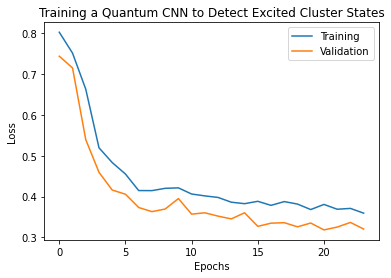

In [22]:
plt.plot(history.history['loss'][1:], label='Training')
plt.plot(history.history['val_loss'][1:], label='Validation')
plt.title('Training a Quantum CNN to Detect Excited Cluster States')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 2. Hybrid models

You don't have to go from eight qubits to one qubit using quantum convolution—you could have done one or two rounds of quantum convolution and fed the results into a classical neural network. This section explores quantum-classical hybrid models.

### 2.1 Hybrid model with a single quantum filter

Apply one layer of quantum convolution, reading out $\langle \hat{Z}_n \rangle$ on all bits, followed by a densely-connected neural network.

<img src="./images/qcnn_5.png" width="1000">

#### 2.1.1 Model definition

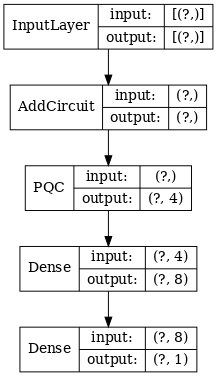

In [23]:
# 1-local operators to read out
readouts = [cirq.Z(bit) for bit in cluster_state_bits[4:]]


def multi_readout_model_circuit(qubits):
    """Make a model circuit with less quantum pool and conv operations."""
    model_circuit = cirq.Circuit()
    symbols = sympy.symbols('qconv0:21')
    model_circuit += quantum_conv_circuit(qubits, symbols[0:15])
    model_circuit += quantum_pool_circuit(qubits[:4], qubits[4:],
                                          symbols[15:21])
    return model_circuit


# Build a model enacting the logic in 2.1 of this notebook.
excitation_input_dual = tf.keras.Input(shape=(), dtype=tf.dtypes.string)

cluster_state_dual = tfq.layers.AddCircuit()(
    excitation_input_dual, prepend=cluster_state_circuit(cluster_state_bits))

quantum_model_dual = tfq.layers.PQC(
    multi_readout_model_circuit(cluster_state_bits),
    readouts)(cluster_state_dual)

d1_dual = tf.keras.layers.Dense(8)(quantum_model_dual)

d2_dual = tf.keras.layers.Dense(1)(d1_dual)

hybrid_model = tf.keras.Model(inputs=[excitation_input_dual], outputs=[d2_dual])

# Display the model architecture
tf.keras.utils.plot_model(hybrid_model,
                          show_shapes=True,
                          show_layer_names=False,
                          dpi=70)

#### 2.1.2 Train the model

In [24]:
hybrid_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
                     loss=tf.losses.mse,
                     metrics=[custom_accuracy])

hybrid_history = hybrid_model.fit(x=train_excitations,
                                  y=train_labels,
                                  batch_size=16,
                                  epochs=25,
                                  verbose=1,
                                  validation_data=(test_excitations,
                                                   test_labels))

Train on 112 samples, validate on 48 samples
Epoch 1/25


 16/112 [===>..........................] - ETA: 4s - loss: 0.9723 - custom_accuracy: 0.5625

 32/112 [=======>......................] - ETA: 2s - loss: 0.9531 - custom_accuracy: 0.5938

 48/112 [===========>..................] - ETA: 1s - loss: 0.9585 - custom_accuracy: 0.5625

 64/112 [================>.............] - ETA: 0s - loss: 0.9794 - custom_accuracy: 0.5156

 80/112 [====================>.........] - ETA: 0s - loss: 0.9664 - custom_accuracy: 0.5125

 96/112 [========================>.....] - ETA: 0s - loss: 0.9557 - custom_accuracy: 0.5521

112/112 [==============================] - 2s 16ms/sample - loss: 0.9270 - custom_accuracy: 0.5893 - val_loss: 0.7528 - val_custom_accuracy: 0.8542


Epoch 2/25
 16/112 [===>..........................] - ETA: 0s - loss: 0.8289 - custom_accuracy: 0.6875

 32/112 [=======>......................] - ETA: 0s - loss: 0.7219 - custom_accuracy: 0.8438

 48/112 [===========>..................] - ETA: 0s - loss: 0.6996 - custom_accuracy: 0.8333

 64/112 [================>.............] - ETA: 0s - loss: 0.6598 - custom_accuracy: 0.8594

 80/112 [====================>.........] - ETA: 0s - loss: 0.6174 - custom_accuracy: 0.8625

 96/112 [========================>.....] - ETA: 0s - loss: 0.6421 - custom_accuracy: 0.8438

112/112 [==============================] - 1s 9ms/sample - loss: 0.6981 - custom_accuracy: 0.8036 - val_loss: 0.3373 - val_custom_accuracy: 0.8958


Epoch 3/25
 16/112 [===>..........................] - ETA: 0s - loss: 0.2060 - custom_accuracy: 1.0000

 32/112 [=======>......................] - ETA: 0s - loss: 0.2598 - custom_accuracy: 0.9688

 48/112 [===========>..................] - ETA: 0s - loss: 0.2796 - custom_accuracy: 0.9583

 64/112 [================>.............] - ETA: 0s - loss: 0.3240 - custom_accuracy: 0.9219

 80/112 [====================>.........] - ETA: 0s - loss: 0.3058 - custom_accuracy: 0.9375

 96/112 [========================>.....] - ETA: 0s - loss: 0.3420 - custom_accuracy: 0.9271

112/112 [==============================] - 1s 9ms/sample - loss: 0.3564 - custom_accuracy: 0.9196 - val_loss: 0.4156 - val_custom_accuracy: 0.8958


Epoch 4/25
 16/112 [===>..........................] - ETA: 0s - loss: 0.6191 - custom_accuracy: 0.8125

 32/112 [=======>......................] - ETA: 0s - loss: 0.4445 - custom_accuracy: 0.8750

 48/112 [===========>..................] - ETA: 0s - loss: 0.4487 - custom_accuracy: 0.8750

 64/112 [================>.............] - ETA: 0s - loss: 0.3862 - custom_accuracy: 0.9062

 80/112 [====================>.........] - ETA: 0s - loss: 0.3537 - custom_accuracy: 0.9250

 96/112 [========================>.....] - ETA: 0s - loss: 0.3320 - custom_accuracy: 0.9167

112/112 [==============================] - 1s 9ms/sample - loss: 0.3130 - custom_accuracy: 0.9286 - val_loss: 0.1974 - val_custom_accuracy: 0.9375


Epoch 5/25
 16/112 [===>..........................] - ETA: 0s - loss: 0.2323 - custom_accuracy: 1.0000

 32/112 [=======>......................] - ETA: 0s - loss: 0.2886 - custom_accuracy: 1.0000

 48/112 [===========>..................] - ETA: 0s - loss: 0.2886 - custom_accuracy: 0.9792

 64/112 [================>.............] - ETA: 0s - loss: 0.2769 - custom_accuracy: 0.9688

 80/112 [====================>.........] - ETA: 0s - loss: 0.2666 - custom_accuracy: 0.9625

 96/112 [========================>.....] - ETA: 0s - loss: 0.2605 - custom_accuracy: 0.9583

112/112 [==============================] - 1s 9ms/sample - loss: 0.2548 - custom_accuracy: 0.9554 - val_loss: 0.1981 - val_custom_accuracy: 0.9792


Epoch 6/25
 16/112 [===>..........................] - ETA: 0s - loss: 0.1333 - custom_accuracy: 1.0000

 32/112 [=======>......................] - ETA: 0s - loss: 0.2067 - custom_accuracy: 0.9688

 48/112 [===========>..................] - ETA: 0s - loss: 0.2478 - custom_accuracy: 0.9583

 64/112 [================>.............] - ETA: 0s - loss: 0.2389 - custom_accuracy: 0.9688

 80/112 [====================>.........] - ETA: 0s - loss: 0.2485 - custom_accuracy: 0.9625

 96/112 [========================>.....] - ETA: 0s - loss: 0.2498 - custom_accuracy: 0.9583

112/112 [==============================] - 1s 9ms/sample - loss: 0.2405 - custom_accuracy: 0.9643 - val_loss: 0.2037 - val_custom_accuracy: 0.9583


Epoch 7/25
 16/112 [===>..........................] - ETA: 0s - loss: 0.1977 - custom_accuracy: 0.9375

 32/112 [=======>......................] - ETA: 0s - loss: 0.2416 - custom_accuracy: 0.9375

 48/112 [===========>..................] - ETA: 0s - loss: 0.2587 - custom_accuracy: 0.9375

 64/112 [================>.............] - ETA: 0s - loss: 0.2513 - custom_accuracy: 0.9375

 80/112 [====================>.........] - ETA: 0s - loss: 0.2703 - custom_accuracy: 0.9375

 96/112 [========================>.....] - ETA: 0s - loss: 0.2509 - custom_accuracy: 0.9479

112/112 [==============================] - 1s 9ms/sample - loss: 0.2432 - custom_accuracy: 0.9554 - val_loss: 0.1846 - val_custom_accuracy: 0.9792


Epoch 8/25
 16/112 [===>..........................] - ETA: 0s - loss: 0.2779 - custom_accuracy: 0.9375

 32/112 [=======>......................] - ETA: 0s - loss: 0.2897 - custom_accuracy: 0.9688

 48/112 [===========>..................] - ETA: 0s - loss: 0.2872 - custom_accuracy: 0.9375

 64/112 [================>.............] - ETA: 0s - loss: 0.2459 - custom_accuracy: 0.9531

 80/112 [====================>.........] - ETA: 0s - loss: 0.2481 - custom_accuracy: 0.9375

 96/112 [========================>.....] - ETA: 0s - loss: 0.2490 - custom_accuracy: 0.9375

112/112 [==============================] - 1s 9ms/sample - loss: 0.2470 - custom_accuracy: 0.9464 - val_loss: 0.1872 - val_custom_accuracy: 0.9792


Epoch 9/25
 16/112 [===>..........................] - ETA: 0s - loss: 0.1658 - custom_accuracy: 0.9375

 32/112 [=======>......................] - ETA: 0s - loss: 0.1903 - custom_accuracy: 0.9688

 48/112 [===========>..................] - ETA: 0s - loss: 0.2029 - custom_accuracy: 0.9792

 64/112 [================>.............] - ETA: 0s - loss: 0.2067 - custom_accuracy: 0.9844

 80/112 [====================>.........] - ETA: 0s - loss: 0.2279 - custom_accuracy: 0.9875

 96/112 [========================>.....] - ETA: 0s - loss: 0.2276 - custom_accuracy: 0.9896

112/112 [==============================] - 1s 9ms/sample - loss: 0.2244 - custom_accuracy: 0.9911 - val_loss: 0.1921 - val_custom_accuracy: 0.9583


Epoch 10/25
 16/112 [===>..........................] - ETA: 0s - loss: 0.1564 - custom_accuracy: 1.0000

 32/112 [=======>......................] - ETA: 0s - loss: 0.2269 - custom_accuracy: 1.0000

 48/112 [===========>..................] - ETA: 0s - loss: 0.2146 - custom_accuracy: 1.0000

 64/112 [================>.............] - ETA: 0s - loss: 0.2153 - custom_accuracy: 0.9844

 80/112 [====================>.........] - ETA: 0s - loss: 0.2143 - custom_accuracy: 0.9875

 96/112 [========================>.....] - ETA: 0s - loss: 0.2039 - custom_accuracy: 0.9896

112/112 [==============================] - 1s 9ms/sample - loss: 0.2203 - custom_accuracy: 0.9732 - val_loss: 0.1924 - val_custom_accuracy: 0.9792


Epoch 11/25
 16/112 [===>..........................] - ETA: 0s - loss: 0.3044 - custom_accuracy: 0.9375

 32/112 [=======>......................] - ETA: 0s - loss: 0.2811 - custom_accuracy: 0.9375

 48/112 [===========>..................] - ETA: 0s - loss: 0.2678 - custom_accuracy: 0.9583

 64/112 [================>.............] - ETA: 0s - loss: 0.2243 - custom_accuracy: 0.9688

 80/112 [====================>.........] - ETA: 0s - loss: 0.2088 - custom_accuracy: 0.9750

 96/112 [========================>.....] - ETA: 0s - loss: 0.2229 - custom_accuracy: 0.9583

112/112 [==============================] - 1s 9ms/sample - loss: 0.2159 - custom_accuracy: 0.9554 - val_loss: 0.1954 - val_custom_accuracy: 0.9792


Epoch 12/25
 16/112 [===>..........................] - ETA: 0s - loss: 0.2427 - custom_accuracy: 0.9375

 32/112 [=======>......................] - ETA: 0s - loss: 0.2222 - custom_accuracy: 0.9688

 48/112 [===========>..................] - ETA: 0s - loss: 0.2492 - custom_accuracy: 0.9583

 64/112 [================>.............] - ETA: 0s - loss: 0.2500 - custom_accuracy: 0.9531

 80/112 [====================>.........] - ETA: 0s - loss: 0.2480 - custom_accuracy: 0.9625

 96/112 [========================>.....] - ETA: 0s - loss: 0.2347 - custom_accuracy: 0.9688

112/112 [==============================] - 1s 9ms/sample - loss: 0.2258 - custom_accuracy: 0.9732 - val_loss: 0.1836 - val_custom_accuracy: 0.9792


Epoch 13/25
 16/112 [===>..........................] - ETA: 0s - loss: 0.2156 - custom_accuracy: 1.0000

 32/112 [=======>......................] - ETA: 0s - loss: 0.2154 - custom_accuracy: 1.0000

 48/112 [===========>..................] - ETA: 0s - loss: 0.2011 - custom_accuracy: 1.0000

 64/112 [================>.............] - ETA: 0s - loss: 0.1828 - custom_accuracy: 1.0000

 80/112 [====================>.........] - ETA: 0s - loss: 0.2019 - custom_accuracy: 0.9875

 96/112 [========================>.....] - ETA: 0s - loss: 0.2212 - custom_accuracy: 0.9792

112/112 [==============================] - 1s 9ms/sample - loss: 0.2213 - custom_accuracy: 0.9732 - val_loss: 0.1845 - val_custom_accuracy: 1.0000


Epoch 14/25
 16/112 [===>..........................] - ETA: 0s - loss: 0.2803 - custom_accuracy: 1.0000

 32/112 [=======>......................] - ETA: 0s - loss: 0.2418 - custom_accuracy: 1.0000

 48/112 [===========>..................] - ETA: 0s - loss: 0.2181 - custom_accuracy: 0.9792

 64/112 [================>.............] - ETA: 0s - loss: 0.2126 - custom_accuracy: 0.9844

 80/112 [====================>.........] - ETA: 0s - loss: 0.2428 - custom_accuracy: 0.9750

 96/112 [========================>.....] - ETA: 0s - loss: 0.2254 - custom_accuracy: 0.9792

112/112 [==============================] - 1s 9ms/sample - loss: 0.2255 - custom_accuracy: 0.9821 - val_loss: 0.1807 - val_custom_accuracy: 0.9583


Epoch 15/25
 16/112 [===>..........................] - ETA: 0s - loss: 0.1237 - custom_accuracy: 1.0000

 32/112 [=======>......................] - ETA: 0s - loss: 0.1416 - custom_accuracy: 1.0000

 48/112 [===========>..................] - ETA: 0s - loss: 0.1396 - custom_accuracy: 0.9792

 64/112 [================>.............] - ETA: 0s - loss: 0.1483 - custom_accuracy: 0.9844

 80/112 [====================>.........] - ETA: 0s - loss: 0.1749 - custom_accuracy: 0.9875

 96/112 [========================>.....] - ETA: 0s - loss: 0.2070 - custom_accuracy: 0.9792

112/112 [==============================] - 1s 9ms/sample - loss: 0.2128 - custom_accuracy: 0.9732 - val_loss: 0.1834 - val_custom_accuracy: 0.9792


Epoch 16/25
 16/112 [===>..........................] - ETA: 0s - loss: 0.1522 - custom_accuracy: 1.0000

 32/112 [=======>......................] - ETA: 0s - loss: 0.2391 - custom_accuracy: 0.9688

 48/112 [===========>..................] - ETA: 0s - loss: 0.2538 - custom_accuracy: 0.9792

 64/112 [================>.............] - ETA: 0s - loss: 0.2322 - custom_accuracy: 0.9844

 80/112 [====================>.........] - ETA: 0s - loss: 0.2315 - custom_accuracy: 0.9750

 96/112 [========================>.....] - ETA: 0s - loss: 0.2399 - custom_accuracy: 0.9688

112/112 [==============================] - 1s 9ms/sample - loss: 0.2193 - custom_accuracy: 0.9732 - val_loss: 0.1834 - val_custom_accuracy: 0.9792


Epoch 17/25
 16/112 [===>..........................] - ETA: 0s - loss: 0.1731 - custom_accuracy: 1.0000

 32/112 [=======>......................] - ETA: 0s - loss: 0.1598 - custom_accuracy: 0.9688

 48/112 [===========>..................] - ETA: 0s - loss: 0.1698 - custom_accuracy: 0.9792

 64/112 [================>.............] - ETA: 0s - loss: 0.2262 - custom_accuracy: 0.9844

 80/112 [====================>.........] - ETA: 0s - loss: 0.2171 - custom_accuracy: 0.9875

 96/112 [========================>.....] - ETA: 0s - loss: 0.2111 - custom_accuracy: 0.9896

112/112 [==============================] - 1s 9ms/sample - loss: 0.2116 - custom_accuracy: 0.9911 - val_loss: 0.1928 - val_custom_accuracy: 0.9792


Epoch 18/25
 16/112 [===>..........................] - ETA: 0s - loss: 0.2100 - custom_accuracy: 1.0000

 32/112 [=======>......................] - ETA: 0s - loss: 0.2257 - custom_accuracy: 0.9688

 48/112 [===========>..................] - ETA: 0s - loss: 0.2175 - custom_accuracy: 0.9792

 64/112 [================>.............] - ETA: 0s - loss: 0.2291 - custom_accuracy: 0.9844

 80/112 [====================>.........] - ETA: 0s - loss: 0.2317 - custom_accuracy: 0.9625

 96/112 [========================>.....] - ETA: 0s - loss: 0.2196 - custom_accuracy: 0.9583

112/112 [==============================] - 1s 9ms/sample - loss: 0.2201 - custom_accuracy: 0.9643 - val_loss: 0.2148 - val_custom_accuracy: 0.9583


Epoch 19/25
 16/112 [===>..........................] - ETA: 0s - loss: 0.1851 - custom_accuracy: 1.0000

 32/112 [=======>......................] - ETA: 0s - loss: 0.1927 - custom_accuracy: 1.0000

 48/112 [===========>..................] - ETA: 0s - loss: 0.1995 - custom_accuracy: 0.9792

 64/112 [================>.............] - ETA: 0s - loss: 0.2076 - custom_accuracy: 0.9688

 80/112 [====================>.........] - ETA: 0s - loss: 0.2138 - custom_accuracy: 0.9625

 96/112 [========================>.....] - ETA: 0s - loss: 0.2135 - custom_accuracy: 0.9688

112/112 [==============================] - 1s 9ms/sample - loss: 0.2207 - custom_accuracy: 0.9732 - val_loss: 0.2086 - val_custom_accuracy: 0.9583


Epoch 20/25
 16/112 [===>..........................] - ETA: 0s - loss: 0.2348 - custom_accuracy: 0.9375

 32/112 [=======>......................] - ETA: 0s - loss: 0.2138 - custom_accuracy: 0.9688

 48/112 [===========>..................] - ETA: 0s - loss: 0.2373 - custom_accuracy: 0.9792

 64/112 [================>.............] - ETA: 0s - loss: 0.2345 - custom_accuracy: 0.9688

 80/112 [====================>.........] - ETA: 0s - loss: 0.2540 - custom_accuracy: 0.9625

 96/112 [========================>.....] - ETA: 0s - loss: 0.2493 - custom_accuracy: 0.9688

112/112 [==============================] - 1s 9ms/sample - loss: 0.2359 - custom_accuracy: 0.9732 - val_loss: 0.2271 - val_custom_accuracy: 0.9792


Epoch 21/25
 16/112 [===>..........................] - ETA: 0s - loss: 0.2204 - custom_accuracy: 0.9375

 32/112 [=======>......................] - ETA: 0s - loss: 0.2888 - custom_accuracy: 0.9688

 48/112 [===========>..................] - ETA: 0s - loss: 0.2896 - custom_accuracy: 0.9583

 64/112 [================>.............] - ETA: 0s - loss: 0.2805 - custom_accuracy: 0.9688

 80/112 [====================>.........] - ETA: 0s - loss: 0.2488 - custom_accuracy: 0.9750

 96/112 [========================>.....] - ETA: 0s - loss: 0.2375 - custom_accuracy: 0.9792

112/112 [==============================] - 1s 9ms/sample - loss: 0.2293 - custom_accuracy: 0.9821 - val_loss: 0.2075 - val_custom_accuracy: 0.9792


Epoch 22/25
 16/112 [===>..........................] - ETA: 0s - loss: 0.1650 - custom_accuracy: 1.0000

 32/112 [=======>......................] - ETA: 0s - loss: 0.2441 - custom_accuracy: 0.9688

 48/112 [===========>..................] - ETA: 0s - loss: 0.2468 - custom_accuracy: 0.9792

 64/112 [================>.............] - ETA: 0s - loss: 0.2254 - custom_accuracy: 0.9844

 80/112 [====================>.........] - ETA: 0s - loss: 0.2450 - custom_accuracy: 0.9750

 96/112 [========================>.....] - ETA: 0s - loss: 0.2232 - custom_accuracy: 0.9792

112/112 [==============================] - 1s 10ms/sample - loss: 0.2262 - custom_accuracy: 0.9732 - val_loss: 0.1882 - val_custom_accuracy: 0.9583


Epoch 23/25
 16/112 [===>..........................] - ETA: 0s - loss: 0.2923 - custom_accuracy: 0.9375

 32/112 [=======>......................] - ETA: 0s - loss: 0.2932 - custom_accuracy: 0.9688

 48/112 [===========>..................] - ETA: 0s - loss: 0.2338 - custom_accuracy: 0.9792

 64/112 [================>.............] - ETA: 0s - loss: 0.1955 - custom_accuracy: 0.9844

 80/112 [====================>.........] - ETA: 0s - loss: 0.1871 - custom_accuracy: 0.9875

 96/112 [========================>.....] - ETA: 0s - loss: 0.1994 - custom_accuracy: 0.9896

112/112 [==============================] - 1s 10ms/sample - loss: 0.2109 - custom_accuracy: 0.9732 - val_loss: 0.1905 - val_custom_accuracy: 0.9583


Epoch 24/25
 16/112 [===>..........................] - ETA: 0s - loss: 0.2229 - custom_accuracy: 0.9375

 32/112 [=======>......................] - ETA: 0s - loss: 0.1537 - custom_accuracy: 0.9688

 48/112 [===========>..................] - ETA: 0s - loss: 0.2081 - custom_accuracy: 0.9792

 64/112 [================>.............] - ETA: 0s - loss: 0.2305 - custom_accuracy: 0.9688

 80/112 [====================>.........] - ETA: 0s - loss: 0.2213 - custom_accuracy: 0.9750

 96/112 [========================>.....] - ETA: 0s - loss: 0.2242 - custom_accuracy: 0.9688

112/112 [==============================] - 1s 9ms/sample - loss: 0.2124 - custom_accuracy: 0.9643 - val_loss: 0.1902 - val_custom_accuracy: 0.9583


Epoch 25/25
 16/112 [===>..........................] - ETA: 0s - loss: 0.3044 - custom_accuracy: 0.8750

 32/112 [=======>......................] - ETA: 0s - loss: 0.2258 - custom_accuracy: 0.9375

 48/112 [===========>..................] - ETA: 0s - loss: 0.2038 - custom_accuracy: 0.9583

 64/112 [================>.............] - ETA: 0s - loss: 0.1936 - custom_accuracy: 0.9688

 80/112 [====================>.........] - ETA: 0s - loss: 0.1916 - custom_accuracy: 0.9625

 96/112 [========================>.....] - ETA: 0s - loss: 0.2003 - custom_accuracy: 0.9688

112/112 [==============================] - 1s 9ms/sample - loss: 0.2159 - custom_accuracy: 0.9732 - val_loss: 0.1825 - val_custom_accuracy: 0.9583


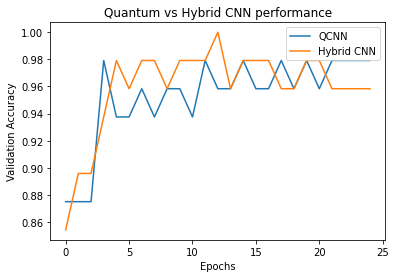

In [25]:
plt.plot(history.history['val_custom_accuracy'], label='QCNN')
plt.plot(hybrid_history.history['val_custom_accuracy'], label='Hybrid CNN')
plt.title('Quantum vs Hybrid CNN performance')
plt.xlabel('Epochs')
plt.legend()
plt.ylabel('Validation Accuracy')
plt.show()

As you can see, with very modest classical assistance, the hybrid model will usually converge faster than the purely quantum version.

### 2.2 Hybrid convolution with multiple quantum filters

Now let's try an architecture that uses multiple quantum convolutions and a classical neural network to combine them.

<img src="./images/qcnn_6.png" width="1000">

#### 2.2.1 Model definition

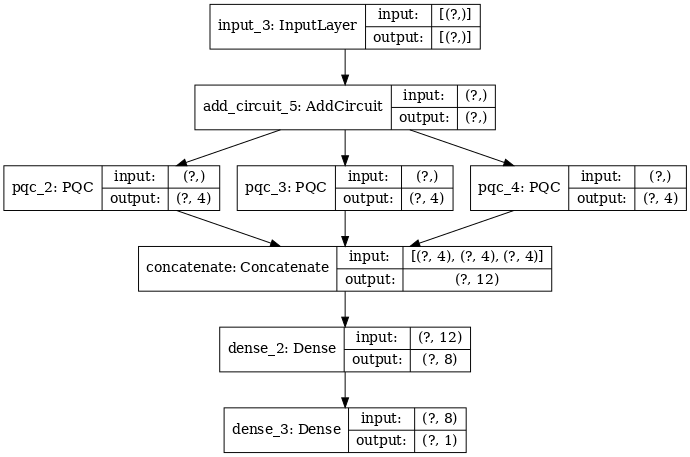

In [26]:
excitation_input_multi = tf.keras.Input(shape=(), dtype=tf.dtypes.string)

cluster_state_multi = tfq.layers.AddCircuit()(
    excitation_input_multi, prepend=cluster_state_circuit(cluster_state_bits))

# apply 3 different filters and measure expectation values

quantum_model_multi1 = tfq.layers.PQC(
    multi_readout_model_circuit(cluster_state_bits),
    readouts)(cluster_state_multi)

quantum_model_multi2 = tfq.layers.PQC(
    multi_readout_model_circuit(cluster_state_bits),
    readouts)(cluster_state_multi)

quantum_model_multi3 = tfq.layers.PQC(
    multi_readout_model_circuit(cluster_state_bits),
    readouts)(cluster_state_multi)

# concatenate outputs and feed into a small classical NN
concat_out = tf.keras.layers.concatenate(
    [quantum_model_multi1, quantum_model_multi2, quantum_model_multi3])

dense_1 = tf.keras.layers.Dense(8)(concat_out)

dense_2 = tf.keras.layers.Dense(1)(dense_1)

multi_qconv_model = tf.keras.Model(inputs=[excitation_input_multi],
                                   outputs=[dense_2])

# Display the model architecture
tf.keras.utils.plot_model(multi_qconv_model,
                          show_shapes=True,
                          show_layer_names=True,
                          dpi=70)

#### 2.2.2 Train the model

In [27]:
multi_qconv_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
    loss=tf.losses.mse,
    metrics=[custom_accuracy])

multi_qconv_history = multi_qconv_model.fit(x=train_excitations,
                                            y=train_labels,
                                            batch_size=16,
                                            epochs=25,
                                            verbose=1,
                                            validation_data=(test_excitations,
                                                             test_labels))

Train on 112 samples, validate on 48 samples
Epoch 1/25


 16/112 [===>..........................] - ETA: 10s - loss: 1.0353 - custom_accuracy: 0.1875

 32/112 [=======>......................] - ETA: 4s - loss: 1.0954 - custom_accuracy: 0.1875 

 48/112 [===========>..................] - ETA: 2s - loss: 1.0553 - custom_accuracy: 0.3333

 64/112 [================>.............] - ETA: 1s - loss: 1.0437 - custom_accuracy: 0.3594

 80/112 [====================>.........] - ETA: 1s - loss: 1.0311 - custom_accuracy: 0.4000

 96/112 [========================>.....] - ETA: 0s - loss: 1.0290 - custom_accuracy: 0.4062

112/112 [==============================] - 3s 30ms/sample - loss: 1.0401 - custom_accuracy: 0.3929 - val_loss: 1.0020 - val_custom_accuracy: 0.4792


Epoch 2/25


 16/112 [===>..........................] - ETA: 1s - loss: 0.9148 - custom_accuracy: 0.6250

 32/112 [=======>......................] - ETA: 1s - loss: 0.9288 - custom_accuracy: 0.5625

 48/112 [===========>..................] - ETA: 0s - loss: 0.9369 - custom_accuracy: 0.5000

 64/112 [================>.............] - ETA: 0s - loss: 0.9149 - custom_accuracy: 0.6094

 80/112 [====================>.........] - ETA: 0s - loss: 0.9139 - custom_accuracy: 0.6250

 96/112 [========================>.....] - ETA: 0s - loss: 0.8897 - custom_accuracy: 0.6771

112/112 [==============================] - 2s 15ms/sample - loss: 0.8804 - custom_accuracy: 0.6875 - val_loss: 0.6638 - val_custom_accuracy: 0.8750


Epoch 3/25


 16/112 [===>..........................] - ETA: 1s - loss: 0.6482 - custom_accuracy: 0.8125

 32/112 [=======>......................] - ETA: 1s - loss: 0.6101 - custom_accuracy: 0.8750

 48/112 [===========>..................] - ETA: 0s - loss: 0.5998 - custom_accuracy: 0.8750

 64/112 [================>.............] - ETA: 0s - loss: 0.5713 - custom_accuracy: 0.8750

 80/112 [====================>.........] - ETA: 0s - loss: 0.5597 - custom_accuracy: 0.8875

 96/112 [========================>.....] - ETA: 0s - loss: 0.5548 - custom_accuracy: 0.8854

112/112 [==============================] - 2s 15ms/sample - loss: 0.5438 - custom_accuracy: 0.8839 - val_loss: 0.3460 - val_custom_accuracy: 0.8958


Epoch 4/25


 16/112 [===>..........................] - ETA: 1s - loss: 0.2327 - custom_accuracy: 1.0000

 32/112 [=======>......................] - ETA: 1s - loss: 0.2783 - custom_accuracy: 0.9375

 48/112 [===========>..................] - ETA: 0s - loss: 0.2605 - custom_accuracy: 0.9375

 64/112 [================>.............] - ETA: 0s - loss: 0.2774 - custom_accuracy: 0.9219

 80/112 [====================>.........] - ETA: 0s - loss: 0.2870 - custom_accuracy: 0.9125

 96/112 [========================>.....] - ETA: 0s - loss: 0.2953 - custom_accuracy: 0.9062

112/112 [==============================] - 2s 15ms/sample - loss: 0.2694 - custom_accuracy: 0.9196 - val_loss: 0.4090 - val_custom_accuracy: 0.8750


Epoch 5/25


 16/112 [===>..........................] - ETA: 1s - loss: 0.2884 - custom_accuracy: 0.9375

 32/112 [=======>......................] - ETA: 1s - loss: 0.2846 - custom_accuracy: 0.9688

 48/112 [===========>..................] - ETA: 0s - loss: 0.2759 - custom_accuracy: 0.9583

 64/112 [================>.............] - ETA: 0s - loss: 0.2871 - custom_accuracy: 0.9531

 80/112 [====================>.........] - ETA: 0s - loss: 0.2826 - custom_accuracy: 0.9500

 96/112 [========================>.....] - ETA: 0s - loss: 0.2857 - custom_accuracy: 0.9479

112/112 [==============================] - 2s 15ms/sample - loss: 0.2706 - custom_accuracy: 0.9554 - val_loss: 0.3804 - val_custom_accuracy: 0.8542


Epoch 6/25


 16/112 [===>..........................] - ETA: 1s - loss: 0.4942 - custom_accuracy: 0.8125

 32/112 [=======>......................] - ETA: 1s - loss: 0.3279 - custom_accuracy: 0.8750

 48/112 [===========>..................] - ETA: 0s - loss: 0.3291 - custom_accuracy: 0.8750

 64/112 [================>.............] - ETA: 0s - loss: 0.3237 - custom_accuracy: 0.9062

 80/112 [====================>.........] - ETA: 0s - loss: 0.3075 - custom_accuracy: 0.9125

 96/112 [========================>.....] - ETA: 0s - loss: 0.2971 - custom_accuracy: 0.9167

112/112 [==============================] - 2s 15ms/sample - loss: 0.2880 - custom_accuracy: 0.9196 - val_loss: 0.2283 - val_custom_accuracy: 0.9583


Epoch 7/25


 16/112 [===>..........................] - ETA: 1s - loss: 0.0981 - custom_accuracy: 1.0000

 32/112 [=======>......................] - ETA: 1s - loss: 0.1258 - custom_accuracy: 1.0000

 48/112 [===========>..................] - ETA: 0s - loss: 0.1853 - custom_accuracy: 0.9583

 64/112 [================>.............] - ETA: 0s - loss: 0.2223 - custom_accuracy: 0.9531

 80/112 [====================>.........] - ETA: 0s - loss: 0.2279 - custom_accuracy: 0.9625

 96/112 [========================>.....] - ETA: 0s - loss: 0.2432 - custom_accuracy: 0.9479

112/112 [==============================] - 2s 15ms/sample - loss: 0.2487 - custom_accuracy: 0.9464 - val_loss: 0.2494 - val_custom_accuracy: 0.9583


Epoch 8/25


 16/112 [===>..........................] - ETA: 1s - loss: 0.1222 - custom_accuracy: 1.0000

 32/112 [=======>......................] - ETA: 1s - loss: 0.2162 - custom_accuracy: 0.9375

 48/112 [===========>..................] - ETA: 0s - loss: 0.2531 - custom_accuracy: 0.9167

 64/112 [================>.............] - ETA: 0s - loss: 0.2785 - custom_accuracy: 0.9375

 80/112 [====================>.........] - ETA: 0s - loss: 0.2642 - custom_accuracy: 0.9375

 96/112 [========================>.....] - ETA: 0s - loss: 0.2578 - custom_accuracy: 0.9479

112/112 [==============================] - 2s 15ms/sample - loss: 0.2494 - custom_accuracy: 0.9554 - val_loss: 0.2392 - val_custom_accuracy: 0.8958


Epoch 9/25
 16/112 [===>..........................] - ETA: 1s - loss: 0.3861 - custom_accuracy: 0.7500

 32/112 [=======>......................] - ETA: 1s - loss: 0.3367 - custom_accuracy: 0.8438

 48/112 [===========>..................] - ETA: 0s - loss: 0.2659 - custom_accuracy: 0.8958

 64/112 [================>.............] - ETA: 0s - loss: 0.2389 - custom_accuracy: 0.9219

 80/112 [====================>.........] - ETA: 0s - loss: 0.2238 - custom_accuracy: 0.9375

 96/112 [========================>.....] - ETA: 0s - loss: 0.2259 - custom_accuracy: 0.9479

112/112 [==============================] - 2s 15ms/sample - loss: 0.2211 - custom_accuracy: 0.9464 - val_loss: 0.2440 - val_custom_accuracy: 0.9167


Epoch 10/25


 16/112 [===>..........................] - ETA: 1s - loss: 0.2332 - custom_accuracy: 0.8750

 32/112 [=======>......................] - ETA: 1s - loss: 0.2778 - custom_accuracy: 0.8750

 48/112 [===========>..................] - ETA: 0s - loss: 0.2953 - custom_accuracy: 0.8750

 64/112 [================>.............] - ETA: 0s - loss: 0.2839 - custom_accuracy: 0.8906

 80/112 [====================>.........] - ETA: 0s - loss: 0.2598 - custom_accuracy: 0.9125

 96/112 [========================>.....] - ETA: 0s - loss: 0.2445 - custom_accuracy: 0.9271

112/112 [==============================] - 2s 15ms/sample - loss: 0.2466 - custom_accuracy: 0.9375 - val_loss: 0.2506 - val_custom_accuracy: 0.9583


Epoch 11/25


 16/112 [===>..........................] - ETA: 1s - loss: 0.2129 - custom_accuracy: 1.0000

 32/112 [=======>......................] - ETA: 1s - loss: 0.2691 - custom_accuracy: 0.9688

 48/112 [===========>..................] - ETA: 0s - loss: 0.2743 - custom_accuracy: 0.9583

 64/112 [================>.............] - ETA: 0s - loss: 0.2497 - custom_accuracy: 0.9688

 80/112 [====================>.........] - ETA: 0s - loss: 0.2692 - custom_accuracy: 0.9500

 96/112 [========================>.....] - ETA: 0s - loss: 0.2479 - custom_accuracy: 0.9583

112/112 [==============================] - 2s 15ms/sample - loss: 0.2334 - custom_accuracy: 0.9643 - val_loss: 0.2422 - val_custom_accuracy: 0.9167


Epoch 12/25
 16/112 [===>..........................] - ETA: 1s - loss: 0.2454 - custom_accuracy: 0.9375

 32/112 [=======>......................] - ETA: 1s - loss: 0.1976 - custom_accuracy: 0.9688

 48/112 [===========>..................] - ETA: 0s - loss: 0.1669 - custom_accuracy: 0.9792

 64/112 [================>.............] - ETA: 0s - loss: 0.2216 - custom_accuracy: 0.9375

 80/112 [====================>.........] - ETA: 0s - loss: 0.2293 - custom_accuracy: 0.9375

 96/112 [========================>.....] - ETA: 0s - loss: 0.2347 - custom_accuracy: 0.9479

112/112 [==============================] - 2s 15ms/sample - loss: 0.2394 - custom_accuracy: 0.9464 - val_loss: 0.2161 - val_custom_accuracy: 0.9375


Epoch 13/25


 16/112 [===>..........................] - ETA: 1s - loss: 0.1760 - custom_accuracy: 1.0000

 32/112 [=======>......................] - ETA: 1s - loss: 0.1233 - custom_accuracy: 1.0000

 48/112 [===========>..................] - ETA: 0s - loss: 0.1776 - custom_accuracy: 1.0000

 64/112 [================>.............] - ETA: 0s - loss: 0.1791 - custom_accuracy: 1.0000

 80/112 [====================>.........] - ETA: 0s - loss: 0.2077 - custom_accuracy: 0.9875

 96/112 [========================>.....] - ETA: 0s - loss: 0.1997 - custom_accuracy: 0.9896

112/112 [==============================] - 2s 15ms/sample - loss: 0.2274 - custom_accuracy: 0.9643 - val_loss: 0.2517 - val_custom_accuracy: 0.9375


Epoch 14/25
 16/112 [===>..........................] - ETA: 1s - loss: 0.2216 - custom_accuracy: 1.0000

 32/112 [=======>......................] - ETA: 1s - loss: 0.3105 - custom_accuracy: 0.9375

 48/112 [===========>..................] - ETA: 0s - loss: 0.2786 - custom_accuracy: 0.9167

 64/112 [================>.............] - ETA: 0s - loss: 0.2514 - custom_accuracy: 0.9219

 80/112 [====================>.........] - ETA: 0s - loss: 0.2461 - custom_accuracy: 0.9125

 96/112 [========================>.....] - ETA: 0s - loss: 0.2265 - custom_accuracy: 0.9271

112/112 [==============================] - 2s 15ms/sample - loss: 0.2403 - custom_accuracy: 0.9375 - val_loss: 0.2148 - val_custom_accuracy: 0.9167


Epoch 15/25


 16/112 [===>..........................] - ETA: 1s - loss: 0.2836 - custom_accuracy: 0.9375

 32/112 [=======>......................] - ETA: 1s - loss: 0.2328 - custom_accuracy: 0.9375

 48/112 [===========>..................] - ETA: 0s - loss: 0.2175 - custom_accuracy: 0.9583

 64/112 [================>.............] - ETA: 0s - loss: 0.2261 - custom_accuracy: 0.9531

 80/112 [====================>.........] - ETA: 0s - loss: 0.2379 - custom_accuracy: 0.9625

 96/112 [========================>.....] - ETA: 0s - loss: 0.2231 - custom_accuracy: 0.9688

112/112 [==============================] - 2s 15ms/sample - loss: 0.2084 - custom_accuracy: 0.9732 - val_loss: 0.2218 - val_custom_accuracy: 0.9375


Epoch 16/25


 16/112 [===>..........................] - ETA: 1s - loss: 0.1505 - custom_accuracy: 1.0000

 32/112 [=======>......................] - ETA: 1s - loss: 0.1239 - custom_accuracy: 1.0000

 48/112 [===========>..................] - ETA: 0s - loss: 0.1734 - custom_accuracy: 0.9583

 64/112 [================>.............] - ETA: 0s - loss: 0.2038 - custom_accuracy: 0.9688

 80/112 [====================>.........] - ETA: 0s - loss: 0.1944 - custom_accuracy: 0.9625

 96/112 [========================>.....] - ETA: 0s - loss: 0.2044 - custom_accuracy: 0.9583

112/112 [==============================] - 2s 15ms/sample - loss: 0.2134 - custom_accuracy: 0.9464 - val_loss: 0.2156 - val_custom_accuracy: 0.9375


Epoch 17/25
 16/112 [===>..........................] - ETA: 1s - loss: 0.1792 - custom_accuracy: 0.9375

 32/112 [=======>......................] - ETA: 1s - loss: 0.1925 - custom_accuracy: 0.9375

 48/112 [===========>..................] - ETA: 0s - loss: 0.2120 - custom_accuracy: 0.9375

 64/112 [================>.............] - ETA: 0s - loss: 0.2385 - custom_accuracy: 0.9375

 80/112 [====================>.........] - ETA: 0s - loss: 0.2116 - custom_accuracy: 0.9500

 96/112 [========================>.....] - ETA: 0s - loss: 0.2120 - custom_accuracy: 0.9583

112/112 [==============================] - 2s 14ms/sample - loss: 0.2174 - custom_accuracy: 0.9554 - val_loss: 0.2580 - val_custom_accuracy: 0.9167


Epoch 18/25


 16/112 [===>..........................] - ETA: 1s - loss: 0.2632 - custom_accuracy: 1.0000

 32/112 [=======>......................] - ETA: 1s - loss: 0.2503 - custom_accuracy: 0.9688

 48/112 [===========>..................] - ETA: 0s - loss: 0.2541 - custom_accuracy: 0.9375

 64/112 [================>.............] - ETA: 0s - loss: 0.2501 - custom_accuracy: 0.9219

 80/112 [====================>.........] - ETA: 0s - loss: 0.2372 - custom_accuracy: 0.9375

 96/112 [========================>.....] - ETA: 0s - loss: 0.2327 - custom_accuracy: 0.9375

112/112 [==============================] - 2s 15ms/sample - loss: 0.2090 - custom_accuracy: 0.9464 - val_loss: 0.2155 - val_custom_accuracy: 0.9375


Epoch 19/25
 16/112 [===>..........................] - ETA: 1s - loss: 0.3402 - custom_accuracy: 0.8750

 32/112 [=======>......................] - ETA: 1s - loss: 0.3255 - custom_accuracy: 0.9062

 48/112 [===========>..................] - ETA: 0s - loss: 0.2713 - custom_accuracy: 0.9375

 64/112 [================>.............] - ETA: 0s - loss: 0.2148 - custom_accuracy: 0.9531

 80/112 [====================>.........] - ETA: 0s - loss: 0.2156 - custom_accuracy: 0.9500

 96/112 [========================>.....] - ETA: 0s - loss: 0.2085 - custom_accuracy: 0.9583

112/112 [==============================] - 2s 15ms/sample - loss: 0.2090 - custom_accuracy: 0.9554 - val_loss: 0.2130 - val_custom_accuracy: 0.9375


Epoch 20/25


 16/112 [===>..........................] - ETA: 1s - loss: 0.0833 - custom_accuracy: 1.0000

 32/112 [=======>......................] - ETA: 1s - loss: 0.1913 - custom_accuracy: 0.9375

 48/112 [===========>..................] - ETA: 0s - loss: 0.1930 - custom_accuracy: 0.9583

 64/112 [================>.............] - ETA: 0s - loss: 0.1953 - custom_accuracy: 0.9688

 80/112 [====================>.........] - ETA: 0s - loss: 0.2398 - custom_accuracy: 0.9375

 96/112 [========================>.....] - ETA: 0s - loss: 0.2183 - custom_accuracy: 0.9479

112/112 [==============================] - 2s 15ms/sample - loss: 0.2104 - custom_accuracy: 0.9464 - val_loss: 0.2222 - val_custom_accuracy: 0.9375


Epoch 21/25


 16/112 [===>..........................] - ETA: 1s - loss: 0.1984 - custom_accuracy: 0.8750

 32/112 [=======>......................] - ETA: 1s - loss: 0.2267 - custom_accuracy: 0.9062

 48/112 [===========>..................] - ETA: 0s - loss: 0.2194 - custom_accuracy: 0.9167

 64/112 [================>.............] - ETA: 0s - loss: 0.1867 - custom_accuracy: 0.9375

 80/112 [====================>.........] - ETA: 0s - loss: 0.1862 - custom_accuracy: 0.9375

 96/112 [========================>.....] - ETA: 0s - loss: 0.1986 - custom_accuracy: 0.9375

112/112 [==============================] - 2s 15ms/sample - loss: 0.2065 - custom_accuracy: 0.9464 - val_loss: 0.2361 - val_custom_accuracy: 0.9375


Epoch 22/25


 16/112 [===>..........................] - ETA: 1s - loss: 0.2236 - custom_accuracy: 0.9375

 32/112 [=======>......................] - ETA: 1s - loss: 0.2107 - custom_accuracy: 0.9375

 48/112 [===========>..................] - ETA: 0s - loss: 0.2395 - custom_accuracy: 0.9375

 64/112 [================>.............] - ETA: 0s - loss: 0.2351 - custom_accuracy: 0.9375

 80/112 [====================>.........] - ETA: 0s - loss: 0.2337 - custom_accuracy: 0.9375

 96/112 [========================>.....] - ETA: 0s - loss: 0.2289 - custom_accuracy: 0.9479

112/112 [==============================] - 2s 15ms/sample - loss: 0.2073 - custom_accuracy: 0.9554 - val_loss: 0.2168 - val_custom_accuracy: 0.9375


Epoch 23/25


 16/112 [===>..........................] - ETA: 1s - loss: 0.1158 - custom_accuracy: 1.0000

 32/112 [=======>......................] - ETA: 1s - loss: 0.2389 - custom_accuracy: 0.9062

 48/112 [===========>..................] - ETA: 0s - loss: 0.2169 - custom_accuracy: 0.9375

 64/112 [================>.............] - ETA: 0s - loss: 0.2282 - custom_accuracy: 0.9375

 80/112 [====================>.........] - ETA: 0s - loss: 0.2160 - custom_accuracy: 0.9375

 96/112 [========================>.....] - ETA: 0s - loss: 0.1984 - custom_accuracy: 0.9479

112/112 [==============================] - 2s 14ms/sample - loss: 0.2034 - custom_accuracy: 0.9464 - val_loss: 0.2156 - val_custom_accuracy: 0.9375


Epoch 24/25
 16/112 [===>..........................] - ETA: 1s - loss: 0.1020 - custom_accuracy: 1.0000

 32/112 [=======>......................] - ETA: 1s - loss: 0.1470 - custom_accuracy: 0.9688

 48/112 [===========>..................] - ETA: 0s - loss: 0.1713 - custom_accuracy: 0.9792

 64/112 [================>.............] - ETA: 0s - loss: 0.1803 - custom_accuracy: 0.9688

 80/112 [====================>.........] - ETA: 0s - loss: 0.1895 - custom_accuracy: 0.9625

 96/112 [========================>.....] - ETA: 0s - loss: 0.2042 - custom_accuracy: 0.9583

112/112 [==============================] - 2s 15ms/sample - loss: 0.2021 - custom_accuracy: 0.9643 - val_loss: 0.2318 - val_custom_accuracy: 0.9375


Epoch 25/25
 16/112 [===>..........................] - ETA: 1s - loss: 0.3480 - custom_accuracy: 0.8125

 32/112 [=======>......................] - ETA: 1s - loss: 0.2832 - custom_accuracy: 0.9062

 48/112 [===========>..................] - ETA: 0s - loss: 0.2733 - custom_accuracy: 0.9167

 64/112 [================>.............] - ETA: 0s - loss: 0.2672 - custom_accuracy: 0.9062

 80/112 [====================>.........] - ETA: 0s - loss: 0.2453 - custom_accuracy: 0.9125

 96/112 [========================>.....] - ETA: 0s - loss: 0.2256 - custom_accuracy: 0.9271

112/112 [==============================] - 2s 15ms/sample - loss: 0.2045 - custom_accuracy: 0.9375 - val_loss: 0.2335 - val_custom_accuracy: 0.9167


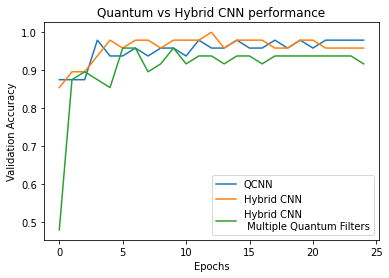

In [28]:
plt.plot(history.history['val_custom_accuracy'][:25], label='QCNN')
plt.plot(hybrid_history.history['val_custom_accuracy'][:25], label='Hybrid CNN')
plt.plot(multi_qconv_history.history['val_custom_accuracy'][:25],
         label='Hybrid CNN \n Multiple Quantum Filters')
plt.title('Quantum vs Hybrid CNN performance')
plt.xlabel('Epochs')
plt.legend()
plt.ylabel('Validation Accuracy')
plt.show()